### Analyze and visualige the patterns in social media data to understand public opinion and attitudes towards specific topics or brands.

In [1]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud,STOPWORDS


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

nltk.download('stopwords')
nltk.download('wordnet')
import warnings
warnings.filterwarnings("ignore")



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\venka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\venka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

## Load Data

In [4]:
twitter_train=pd.read_csv(r'E:\Download\twitter_training.csv')
twitter_validation=pd.read_csv(r'E:\Download\twitter_validation.csv') 

In [5]:
#At first put name for each column:
#At the second step add two data frame to the one dataframe to analysis


column_name=['tweetID','entity','sentiment','tweet_content']
twitter_train.columns=column_name
twitter_validation.columns=column_name
twitter=pd.concat([twitter_train,twitter_validation],ignore_index=False)
twitter.head()

,tweetID,entity,sentiment,tweet_content
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [6]:
# show the columns names of the data set
twitter.columns.tolist()

['tweetID', 'entity', 'sentiment', 'tweet_content']

In [7]:
#the info for eac column
#info content:(name of column,nonnull values in the data,type of the column)

twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75680 entries, 0 to 998
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tweetID        75680 non-null  int64 
 1   entity         75680 non-null  object
 2   sentiment      75680 non-null  object
 3   tweet_content  74994 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.9+ MB


## Data cleaning 

### Remove null values

In [8]:
#Before remove null values
twitter.isnull().sum()

tweetID            0
entity             0
sentiment          0
tweet_content    686
dtype: int64

In [9]:
#after remove null values
twitter=twitter.dropna()
twitter.isnull().sum()

tweetID          0
entity           0
sentiment        0
tweet_content    0
dtype: int64

### Remove Duplicate values

In [10]:
#Before remove
twitter_duplicated = twitter.duplicated().sum()
print(f"There are {twitter_duplicated} duplicate values in the dataset")

There are 2856 duplicate values in the dataset


In [11]:
#After remove
twitter = twitter.drop_duplicates()
twitter_remove_duplicated = twitter.duplicated().sum()
print(f"There are {twitter_remove_duplicated} duplicate values in the dataset")

There are 0 duplicate values in the dataset


### Removing outliers

[Text(0.5, 1.0, 'Distribution of tweet_content length')]

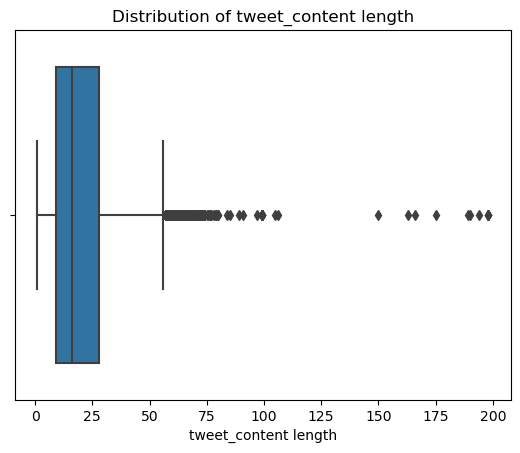

In [12]:
#Identify outliners on tweet content length
twitter["tweet_content length"] = twitter["tweet_content"].map(lambda x:len(x.split(" ")))
sns.boxplot(x="tweet_content length",data=twitter).set(title='Distribution of tweet_content length')

In [13]:
#Using Outlier Formula to remove rows

lower_quartile = np.percentile(twitter["tweet_content length"],25) #Calculating lower_quartile
median = np.percentile(twitter["tweet_content length"],50) #Calculating median
upper_quartile = np.percentile(twitter["tweet_content length"],75) #Calculating upper_quartile

interquartile_range = upper_quartile - lower_quartile #Calculating interquartile_range(IQR)
lower_boundary = lower_quartile - 1.5*interquartile_range #Calculating lower_boundary
upper_boundary = upper_quartile + 1.5*interquartile_range #Calculating upper_boundary

#tweet content length smaller than lower_boundary or larger than upper_boundary will be removed
print("lower_boundary:",lower_boundary)
print("upper_boundary:",upper_boundary)

lower_boundary: -19.5
upper_boundary: 56.5


In [14]:
#Remove outliers
removed_twitter = twitter[(twitter["tweet_content length"]>=lower_boundary)&(twitter["tweet_content length"]<=upper_boundary)]

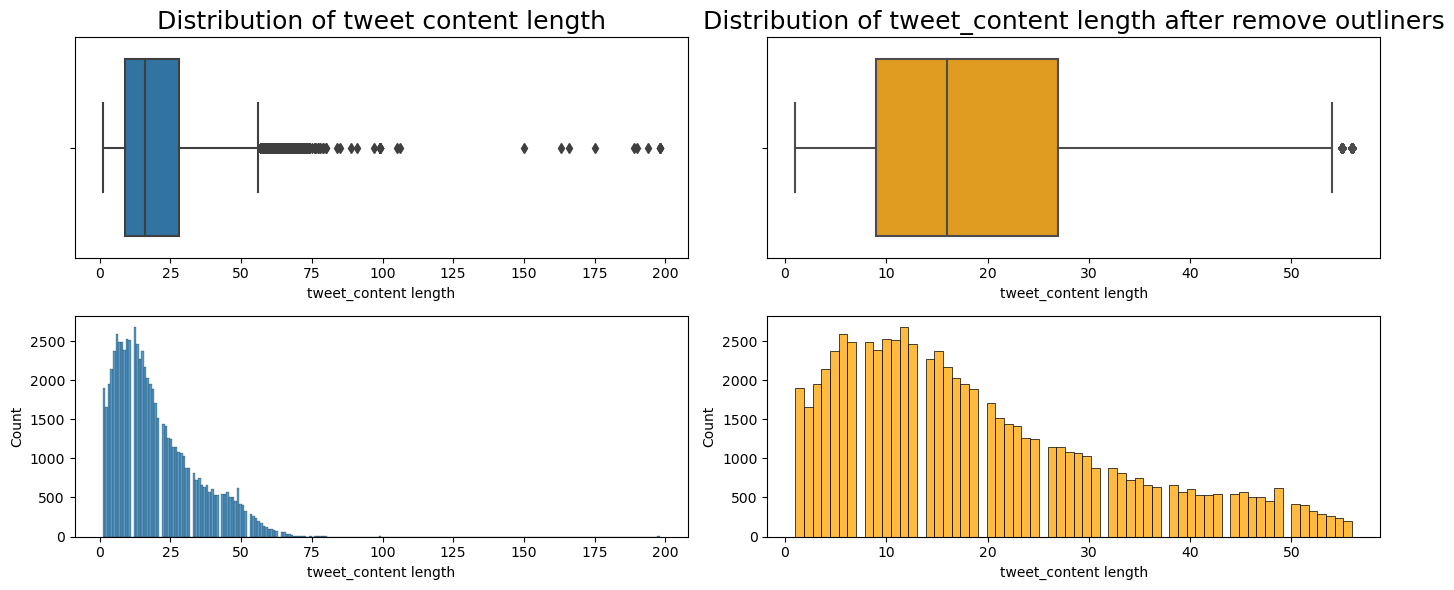

In [15]:
#Compare the distribution of tweet content length before and after remove outliers

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,6))

#distribution of tweet content length
sns.boxplot(x="tweet_content length",data=twitter,ax=ax[0,0]).set_title("Distribution of tweet content length",fontsize=18)
sns.boxplot(x="tweet_content length",data=removed_twitter,ax=ax[0,1],color="orange").set_title("Distribution of tweet_content length after remove outliners",fontsize=18)

#frequency of tweet content length
sns.histplot(x="tweet_content length",data=twitter,ax=ax[1,0])
sns.histplot(x="tweet_content length",data=removed_twitter,ax=ax[1,1],color="orange")
             
fig.tight_layout()

The tweet content length skewness is reduced after removing outliers, meaning that it has a more even distribution.

### Distribution of lables after Data cleaning

<Axes: xlabel='sentiment', ylabel='count'>

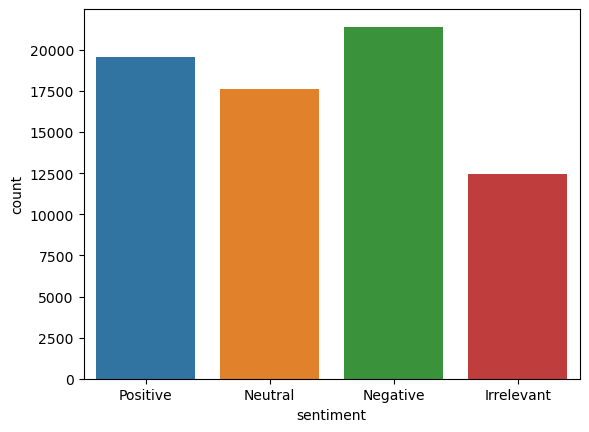

In [16]:
sns.countplot(x="sentiment",data=removed_twitter)

Distribution of sentiment is balanced, therefore resampling is not required.

The above figure we can see the number of the negative reactions are above to 20000

the min number of the reactions are the number of the irrelevant reactions are less tan 15000
reactions

## Exploratory Data Analysis

### Frequency of words (wordcloud)

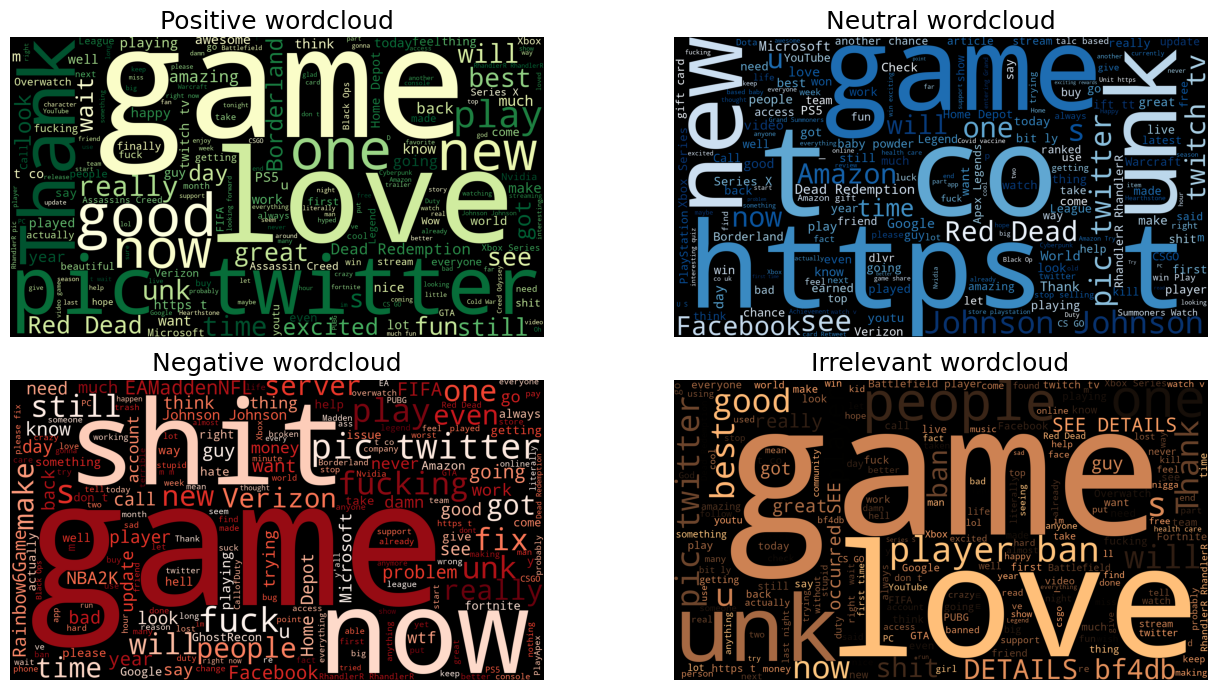

In [17]:
sentiment_list=["Positive","Neutral","Negative","Irrelevant"]
colormap_list=["YlGn_r","Blues_r","Reds_r","copper_r"]
ax_list = [[0,0],[0,1],[1,0],[1,1]]
stopwords_set = set(STOPWORDS)


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,7))
for sentiment,(row,col),colormap in zip(sentiment_list,ax_list,colormap_list):
    
    #Create wordcloud for each sentiment
    text = " ".join(content for content in removed_twitter[removed_twitter["sentiment"]==sentiment]["tweet_content"])
    wordcloud = WordCloud(colormap=colormap, stopwords=stopwords_set, width=1600, height=900).generate(text)
    
    #Plot wordcloud
    ax[row,col].imshow(wordcloud)
    ax[row,col].set_title(sentiment+" wordcloud", fontsize=18)
    ax[row,col].axis('off')
    
fig.tight_layout()

### Frequency of entity

Text(0.5, 1.0, 'Frequency of entity')

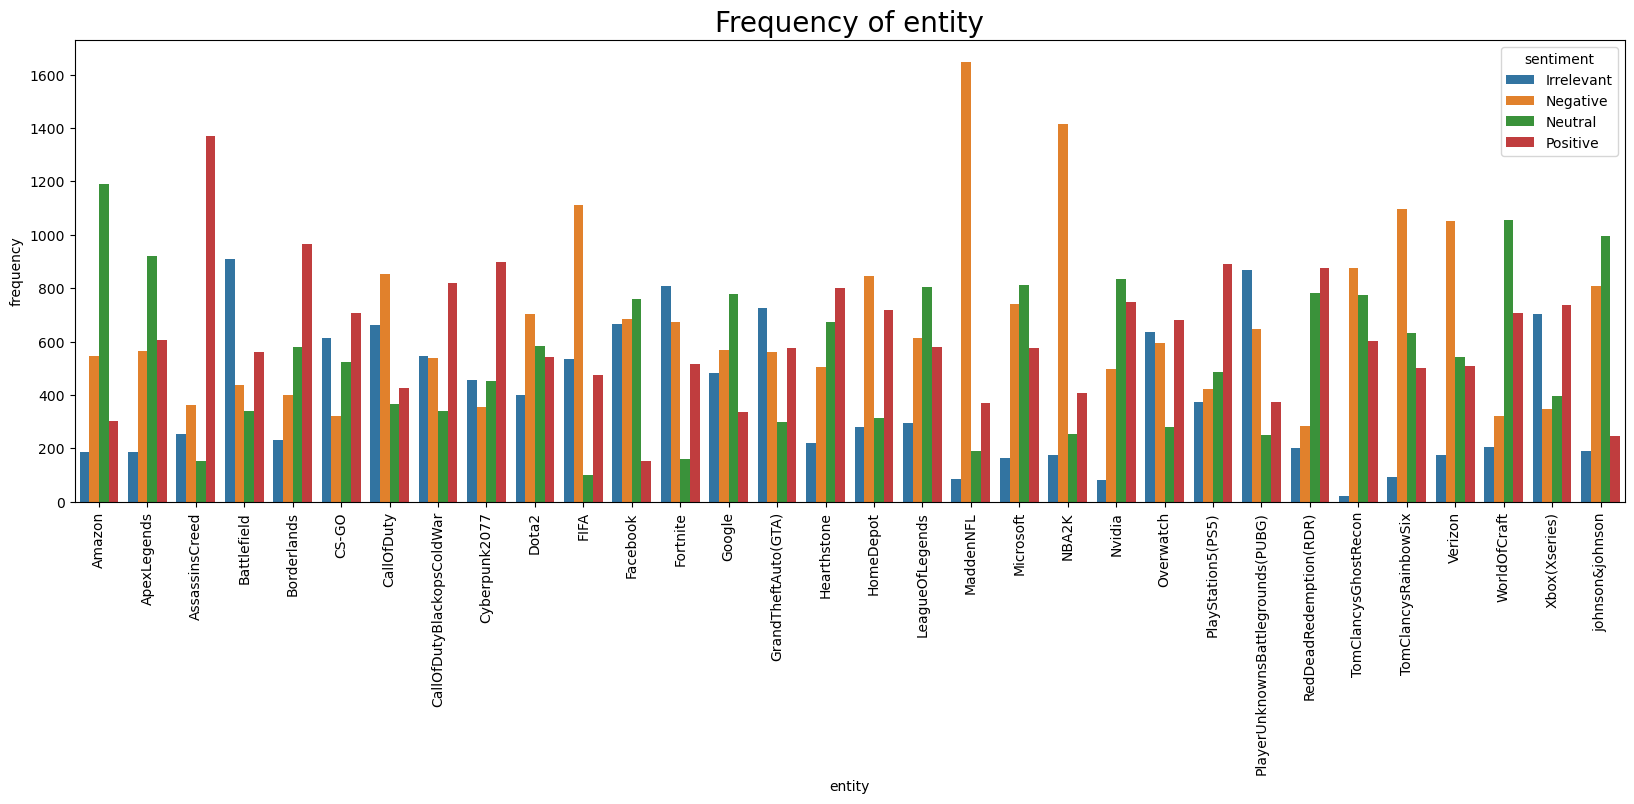

In [18]:
entity_frequency = removed_twitter.groupby(["sentiment","entity"]).size().reset_index()
entity_frequency.rename(columns={0: 'frequency'}, inplace=True)

plt.figure(figsize=(20,6))
plt.xticks(rotation=90)
sns.barplot(data=entity_frequency,x="entity",y="frequency",hue="sentiment").set_title("Frequency of entity", fontsize=20)

1.From the above figure the highest negative reactions in the MaddenNFL entity

2.The highest irrelevant reactions in the Battlefield entity

3.The highest neutral reactions in the Amazon entity

4.The highest positive reactions in the AssassinsCreed entity


## Data Splitting

In [19]:
#Split the training and validation dataset into x_train, y_train, x_test and y_test
x_train = twitter["entity"] + " " + twitter["tweet_content"]
y_train = twitter["sentiment"]
x_test = twitter_validation["entity"] + " " + twitter_validation["tweet_content"]
y_test = twitter_validation["sentiment"]

In [20]:
x_train.head()

0    Borderlands I am coming to the borders and I w...
1    Borderlands im getting on borderlands and i wi...
2    Borderlands im coming on borderlands and i wil...
3    Borderlands im getting on borderlands 2 and i ...
4    Borderlands im getting into borderlands and i ...
dtype: object

### Text Preprocessing

In [21]:
# function turns pos_tag into wordnet_pos
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [22]:
def text_preprocessing(text):
    
    #tokenize
    text_tokenize = word_tokenize(text)

    #split text and entity
    entity = text_tokenize[0]
    text_content = text_tokenize[1:]

    #pos tagging
    text_pos = pos_tag(text_content)
        
    #remove punctuation and stopwords
    remove_words = set(list(string.punctuation) + stopwords.words('english'))    
    text_remove = [(word,pos) for (word,pos) in text_pos if word not in remove_words]
    
    #lemmaization
    word_lem = WordNetLemmatizer()   
    text_lem = [(word_lem.lemmatize(word,pos=get_wordnet_pos(pos)),pos) if get_wordnet_pos(pos) != None
                 else (word_lem.lemmatize(word),pos) for (word,pos) in text_remove]

    #combine text and entity
    text_lem.append((entity,))

    return text_lem

In [23]:
#test text_preprocessing
example_text = "Overwatch Overwatch is a wonderful game, even after so many years."
print("Original sentence: ", example_text)
print("After text_preprocessing: ", text_preprocessing(example_text))

Original sentence:  Overwatch Overwatch is a wonderful game, even after so many years.
After text_preprocessing:  [('Overwatch', 'NN'), ('wonderful', 'JJ'), ('game', 'NN'), ('even', 'RB'), ('many', 'JJ'), ('year', 'NNS'), ('Overwatch',)]


In [24]:
#Combine text_preprocessing, CountVectorizer and TfidfTransformer into pipeline
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_preprocessing)),
    ('tfidf', TfidfTransformer())
])

#Apply pipeline to x_train and x_test
x_train_processed = pipeline.fit_transform(x_train)
x_test_processed = pipeline.transform(x_test)

## Models

In [25]:
classifier_used = [
    LogisticRegression(),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
]

In [26]:
classifier_accuracy=[]

for classifier in classifier_used:
    
    fit = classifier.fit(x_train_processed, y_train)
    predict = fit.predict(x_test_processed)
    trainset_predict = fit.predict(x_train_processed)
    
    accuracy = accuracy_score(predict,y_test)
    trainset_accuracy = accuracy_score(trainset_predict,y_train)
    
    classifier_accuracy.append([classifier.__class__.__name__,accuracy,trainset_accuracy])

In [27]:
classifier_result = pd.DataFrame(classifier_accuracy,columns=["classifier","accuracy","accuracy on trainset"]).sort_values(by='accuracy',ascending=False)
classifier_result

,classifier,accuracy,accuracy on trainset
2,DecisionTreeClassifier,1.000000,0.986623
3,RandomForestClassifier,1.000000,0.986623
1,KNeighborsClassifier,0.993994,0.961809
0,LogisticRegression,0.959960,0.892983
